### CLASH demo (borrowed from Running Eazy-py on the Riverside test catalogs)

This version of the EAZY code is meant to take in my photometry to estimate the photometric redshfit of my sources.

The photo z's will be saved to my catalog as z_eazy.

In [1]:
%matplotlib inline
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.table import Table

from astropy.utils.exceptions import AstropyWarning
import warnings
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

### Prepare catalogs

In [8]:
## Make flux columns
file    = '/Users/brianmerino/Desktop/catalogs/galaxy_phot.cat' 
newfile = '/Users/brianmerino/EAZY/catalogs/galaxy_phot_flux.fits'


cat = Table.read(file, format='ascii')
print(cat) 
#magnif = (cat["magnif"]) 
magnif = 1.0

abzp = 23.9 # microJy
    
for magerr_col in cat.colnames:
    if magerr_col.endswith('_magerr'):
        mag_col = magerr_col[:-3]
 
        
        flux_col = mag_col.replace("_mag","_flux")
        fluxerr_col = magerr_col.replace("_magerr","_fluxerr")
            
        ###############################################################
        # Replace flux_err with 20% of flux if the magnitudes do not have errors
        for i in range(0,len(cat[magerr_col])):
            flux = 10**(-0.4*(cat[mag_col][i]-abzp))
            
            if np.isinf(cat[magerr_col][i]):
                flux_err = flux*0.2
            elif cat[magerr_col][i] == -99:
                flux_err = flux*0.2
            else:
                flux_err = np.log(10)*flux*cat[magerr_col][i]/2.5 
            
            flux /= magnif
            flux_err /=magnif
            
            bad = (cat[mag_col][i] < -90)
            bad |= cat[mag_col][i] > 90

            if bad:
                flux = -99
                flux_err = -99

            flux_col = mag_col.replace("_mag","_flux")
            fluxerr_col = magerr_col.replace("_magerr","_fluxerr")
            
            if i == 0:
                cat[flux_col] = flux
                cat[fluxerr_col] = flux_err
            else:
                cat[flux_col][i] = flux
                cat[fluxerr_col][i] = flux_err
            
            

###########################################################################################################
# eazy seems to have z_spec hard coded in it, whether we use it or not (GLW 3/23/21)
# eazy has a error in the code, you need at least two objects in the catalog (this is why the prior fails)
###########################################################################################################


#cat['z_spec'] = cat['redshift']
cat['z_spec'] = cat['z_clash']
#cat['z_spec'] = cat['z_eazy']
print(cat.colnames)

cat.write(newfile, overwrite=True)            

#cat[:20].show_in_notebook()
cat.show_in_notebook()


cluster  id          RA         ...    f160w_fluxerr     z_spec
------- ---- ------------------ ... -------------------- ------
   a209  218         22.9730375 ...  0.05639021049076047  0.939
   a209 1020 22.978324999999998 ...   0.0751009938637391  0.488
   a209 1312           22.97045 ...  0.06551423457174192  0.495
   a209 1602           22.96975 ... 0.061654806499936377  0.547
   a209 1669         22.9816125 ...  0.06030254915529669  0.796
   a209 1671          22.979675 ...  0.06515318805918482  0.443
   a209 1708 22.961758333333332 ...  0.04663754395414128  0.817
   a209 1772 22.980629166666667 ...   0.0383167219813899  0.884
   a383   58  42.01558333333333 ...   2.2030786190828233  0.295
   a383  128 42.000504166666666 ...   0.4481568053572105  0.885
    ...  ...                ... ...                  ...    ...
rxj2129  246  322.4055333333333 ...  0.05529131590844749  0.422
rxj2129  259  322.4223833333333 ...  0.06572122891822377  0.918
rxj2129  274  322.4232166666667 ...   0.

idx,cluster,id,RA,DEC,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,f225w_flux,f225w_fluxerr,f275w_flux,f275w_fluxerr,f336w_flux,f336w_fluxerr,f390w_flux,f390w_fluxerr,f435w_flux,f435w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f160w_flux,f160w_fluxerr,z_spec
0,a209,218,22.9730375,-13.5973175,0.939,21.022,0.025,-99.0,-99.0,22.711,0.068,24.107,0.13,24.274,0.114,24.094,0.068,23.743,0.033,23.941,0.068,22.948,0.034,22.67,0.02,22.769,0.06,22.679,0.015,22.58,0.008,22.393,0.012,22.3,0.009,22.298,0.014,14,0,-99,-99,2.989509927814587,0.18723394706790525,0.826418441715795,0.09895073679244823,0.7085981269167676,0.07440130126866958,0.8363729915840239,0.05238230352683446,1.1555799554021289,0.035122839563746,0.9629417129715555,0.06030934235692439,2.4032558049332398,0.07525833347883332,3.104559588128347,0.057188101023488536,2.834001005509097,0.15661268325156918,3.078931309741611,0.042537008016982,3.37287308658869,0.024852247327167787,4.006821541822104,0.04428502825193758,4.365158322401652,0.03618413453419539,4.373206651696452,0.05639021049076047,0.939
1,a209,1020,22.978324999999998,-13.612234166666667,0.488,-99.0,-99.0,-99.0,-99.0,21.628,0.032,22.892,0.055,22.664,0.034,22.573,0.022,21.845,0.007,21.672,0.011,21.32,0.01,21.218,0.007,21.196,0.018,21.105,0.005,21.089,0.003,21.036,0.004,20.947,0.003,20.869,0.005,-99,-99,-99,-99,8.105876824647362,0.23890523061861027,2.5304630494613947,0.1281853429133654,3.121763510848157,0.09775851528547144,3.3946890538007795,0.06878573161355929,6.637430704019088,0.04279309718559492,7.783949326267247,0.07886210500644963,10.764652136298333,0.09914611016122821,11.824968703831036,0.07623839065517492,12.067019095932718,0.200054435667618,13.121998990192008,0.060429038530198084,13.316803762699811,0.036795688596383526,13.982988484658337,0.051515233344450705,15.177491558612486,0.041936958974284885,16.30797361023593,0.0751009938637391,0.488
2,a209,1312,22.97045,-13.616914166666668,0.495,-99.0,-99.0,-99.0,-99.0,21.793,0.036,22.677,0.042,22.647,0.031,22.343,0.016,21.631,0.006,21.464,0.008,21.116,0.008,21.062,0.006,21.001,0.014,20.965,0.004,20.951,0.002,20.896,0.004,20.831,0.003,20.775,0.004,-99,-99,-99,-99,6.963057796029312,0.23087567639222017,3.0846081377571397,0.1193232216242256,3.1710274389478936,0.09053935032891668,4.195657223387249,0.061829489778459326,8.083510373900667,0.04467112916641537,9.427575085274157,0.0694649403341899,12.989726288978538,0.09571184036823951,13.652116950664434,0.07544438634818701,14.441090844161184,0.18621030682429474,14.927944095789943,0.05499657847042305,15.121678487917649,0.027855161173862338,15.907429237502162,0.05860513508820819,16.88884694790917,0.04666560866413637,17.78279410038923,0.06551423457174192,0.495
3,a209,1602,22.96975,-13.621598888888888,0.547,-99.0,-99.0,-99.0,-99.0,22.891,0.087,23.128,0.057,23.884,0.086,22.976,0.026,22.402,0.01,22.288,0.016,22.081,0.016,22.072,0.013,22.152,0.037,22.227,0.011,22.268,0.007,22.304,0.012,22.277,0.01,22.276,0.015,-99,-99,-99,-99,2.5327947656899945,0.20295274639397126,2.036104201131967,0.10689331253384562,1.0148456628180937,0.0803848362243744,2.3420706947938243,0.05608529751313286,3.973745050614623,0.03659954446761641,4.41367143463439,0.06504226592488185,5.340722340937607,0.07870379294760446,5.3851772199752785,0.06447910970720021,5.002648624210048,0.17048155738437978,4.66874334392018,0.047300786837593436,4.495727713019047,0.028985027719642044,4.3491060723245365,0.048068096687924944,4.458615279480697,0.04106536431

### Run the photo-z fits

In [9]:
print('\n####\n')
params = {}

translate_file = 'zphot.translate_nouvis.clash'
#translate_file = 'zphot.translate.clash'

params['CATALOG_FILE'] = newfile
params['MAIN_OUTPUT_FILE'] = 'galaxy_Phot_no_uvis_info.eazypy'

params['PRIOR_FILTER'] = 205
params['PRIOR_ABZP'] = abzp
#params['MW_EBV'] = EBV

# Galactic extinction
params['MW_EBV'] = 0.0 # already accounted for in CLASH
#params['MW_EBV'] = 0.0161 # a209      S & F mean
#params['MW_EBV'] = 0.0170 # a1423     S & F mean
#params['MW_EBV'] = 0.0357 # macs0416  S & F mean
#params['MW_EBV'] = 0.0265 # macs1311  S & F mean
#params['MW_EBV'] = 0.0235 # macs1423  S & F mean

params['Z_MAX'] = 3.0
params['Z_STEP'] = 0.01
params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
params['VERBOSITY'] = 1

###############################################################
#Fix z_phot for clumps
params['FIX_ZSPEC'] = 'n'
###############################################################

print(params)
    
ez = eazy.photoz.PhotoZ(param_file=None,
                        translate_file=translate_file,
                        zeropoint_file=None, params=params,
                        load_prior=True, load_products=False)

for iter in range(2):
    ez.fit_parallel(n_proc=4)
    ez.error_residuals()

print('Get physical parameters')
ez.standard_output()
#zout.show_in_notebook()


####

{'CATALOG_FILE': '/Users/brianmerino/EAZY/catalogs/galaxy_phot_flux.fits', 'MAIN_OUTPUT_FILE': 'galaxy_Phot_no_uvis_info.eazypy', 'PRIOR_FILTER': 205, 'PRIOR_ABZP': 23.9, 'MW_EBV': 0.0, 'Z_MAX': 3.0, 'Z_STEP': 0.01, 'TEMPLATES_FILE': 'templates/fsps_full/tweak_fsps_QSF_12_v3.param', 'VERBOSITY': 1, 'FIX_ZSPEC': 'n'}
Read default param file: /Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/brianmerino/EAZY/catalogs/galaxy_phot_flux.fits
   >>> NOBJ = 161
f435w_flux f435w_fluxerr (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f475w_flux f475w_fluxerr (234): hst/ACS_update_sep07/wfc_f475w_t81.dat
f606w_flux f606w_fluxerr (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f625w_flux f625w_fluxerr (237): hst/ACS_update_sep07/wfc_f625w_t81.dat
f775w_flux f775w_fluxerr (238): hst/ACS_update_sep07/wfc_f775w_t81.dat
f814w_flux f814w_fluxerr (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f850lp_flux f850lp_fluxerr (240): hst/ACS_upd

138it [00:00, 12283.05it/s]


Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=159)
Fit 1.7 s (n_proc=4, NOBJ=161)
`error_residuals`: force uncertainties to match residuals
Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=159)
Fit 1.2 s (n_proc=4, NOBJ=161)
`error_residuals`: force uncertainties to match residuals
Get physical parameters
Get best fit coeffs & best redshifts
fit_best: 0.3 s (n_proc=1,  NOBJ=161)
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])


/Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/photoz.py:4445: RuntimeWarning: covariance is not positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Abs Mag filters [271, 272, 274]
Rest-frame filters: [271, 272, 274]


(<Table length=161>
   id   z_spec ...                ABSM_274 [5]               
               ...                                           
 int64 float64 ...                  float64                  
 ----- ------- ... ------------------------------------------
   218   0.939 ...    -18.93150643242906 .. -19.0609963311107
  1020   0.488 ... -19.497465792812967 .. -19.596672717251444
  1312   0.495 ...  -19.674566513656387 .. -19.77825380003334
  1602   0.547 ...  -17.882692153222422 .. -18.16801624990211
  1669   0.796 ... -21.345182804136037 .. -21.395792392759084
  1671   0.443 ...  -19.40888579271399 .. -19.503953770619262
  1708   0.817 ... -18.269615454375753 .. -18.442442221343526
  1772   0.884 ... -16.376734722203743 .. -16.673548687047493
    58   0.295 ... -17.692987375604062 .. -18.608266764031796
   ...     ... ...                                        ...
   259   0.918 ...  -18.903008893279626 .. -19.26046128585775
   274   0.724 ... -21.400593493923743 .. -21.5990

In [10]:
# Outputs for the z=1 catalog
zout = Table.read('{0}.zout.fits'.format(params['MAIN_OUTPUT_FILE']))
zout['ssfr'] = zout['sfr']/zout['mass']
print(zout.colnames)


['id', 'z_spec', 'nusefilt', 'lc_min', 'lc_max', 'z_phot', 'z_phot_chi2', 'z_phot_risk', 'z_min_risk', 'min_risk', 'z_raw_chi2', 'raw_chi2', 'z025', 'z160', 'z500', 'z840', 'z975', 'restU', 'restU_err', 'restB', 'restB_err', 'restV', 'restV_err', 'restJ', 'restJ_err', 'dL', 'mass', 'sfr', 'Lv', 'LIR', 'MLv', 'Av', 'mass_p', 'sfr_p', 'Lv_p', 'LIR_p', 'ssfr_p', 'rest270', 'rest270_err', 'rest274', 'rest274_err', 'rest120', 'rest120_err', 'rest121', 'rest121_err', 'rest156', 'rest156_err', 'rest157', 'rest157_err', 'rest158', 'rest158_err', 'rest159', 'rest159_err', 'rest160', 'rest160_err', 'rest161', 'rest161_err', 'rest162', 'rest162_err', 'rest163', 'rest163_err', 'DISTMOD', 'ABSM_271', 'ABSM_272', 'ABSM_274', 'ssfr']


In [11]:
#print(cat['cluster'][56])
#print(cat['id'][56])
print(zout['z_phot'])
print(zout['z_spec'])
print(zout['Av'])
print(zout['sfr'])
print(zout['mass'])
print(zout['LIR'])
#print(zout['line_EW_Ha'])
#print(zout['line_EW_O3'])
#print(zout['line_EW_O2'])

  z_phot  
----------
0.84849745
 0.5941091
0.59000254
0.39538866
0.84853584
0.45483628
0.69951457
0.47910675
0.40419292
   1.03047
       ...
 0.6320626
 0.7169288
0.67499787
0.89563924
  0.558075
0.60454834
0.67526186
0.44407612
0.59994733
 0.5967503
0.85457146
Length = 161 rows
z_spec
------
 0.939
 0.488
 0.495
 0.547
 0.796
 0.443
 0.817
 0.884
 0.295
 0.885
   ...
 0.422
 0.918
 0.724
 0.897
 0.423
 0.653
 0.431
 0.388
  0.42
 0.652
 0.944
Length = 161 rows
     Av    
-----------
       1.17
       0.59
       0.33
       0.06
       0.35
       0.21
       0.11
       0.07
       0.49
       0.59
        ...
       0.22
       1.47
       0.67
       1.13
       1.44
       0.30
       0.49
       0.80
       0.33
       0.40
       0.96
Length = 161 rows
    sfr     
solMass / yr
------------
       7.072
       2.248
       0.505
       0.528
      26.569
       1.731
       0.825
       0.189
       2.606
       5.111
         ...
       9.329
      28.309
      17.582
     

In [55]:
updated_file = '/Users/brianmerino/Desktop/catalogs/Galaxy_phot_eazy.cat'
cat2 = Table.read(updated_file, format='ascii')    

#for y in range(0,len(cat)):
#    cat2['z_phot'][y] = round(zout[y]['z_phot'],4)
#    cat2['z_16'][y] = zout['z160'][y]
#    cat2['z_50'][y] = zout['z500'][y]
#    cat2['z_84'][y] = zout['z840'][y]
    
    
#cat2.add_column(-99.0,name='z_phot_eazy',index=-3)


#sources[col].info.format = '%.8g'  # for consistent table output
cat2.show_in_notebook()

#cat2.write(updated_file,format='ascii')

idx,cluster,id,RA,DEC,z_clash,z_phot,z_16,z_50,z_84,z_spec,z_note
0,a209,218,22.973038,-13.597318,0.939,0.8485,0.821992,0.863674,0.899834,-99.0,0
1,a209,1020,22.978325,-13.612234,0.488,0.5941,0.515208,0.577093,0.604328,-99.0,0
2,a209,1312,22.97045,-13.616914,0.495,0.59,0.568169,0.588522,0.60542,0.579,1
3,a209,1602,22.96975,-13.621599,0.547,0.3954,0.317817,0.365143,0.399967,-99.0,0
4,a209,1669,22.981613,-13.621116,0.796,0.8485,0.840772,0.845939,0.8532,-99.0,0
5,a209,1671,22.979675,-13.623325,0.443,0.4548,0.441778,0.456759,0.474134,-99.0,0
6,a209,1708,22.961758,-13.624078,0.817,0.6995,0.670559,0.705968,0.747845,-99.0,0
7,a209,1772,22.980629,-13.625984,0.884,0.4791,0.443964,0.538789,0.670502,-99.0,0
8,a383,58,42.015583,-3.508325,0.295,0.4042,0.289246,0.455276,0.64413,-99.0,0
9,a383,128,42.000504,-3.5116839,0.885,1.0305,0.857795,1.07429,1.58304,-99.0,0


z_phot_eazy = our photometry

z_clash = photometry from CLASH postman et al. 2012

z_connor = photometry Connor et al. 2017

z_note key:

0 = None

1 = MUSE

2 = Connor

3 = arXiv:1509.00475 (T. Treu et al. 2015 [Grism])

4 = arXiv:1704.01159 (Li-Yen Hsu et al. 2017 [SCUBA-2])

5 = arXiv:1511.00686 (Vulcani Benedetta et al. 2015 [GLASS])

6 = arXiv:1511.00033 (Conor McPartland et al. 2015 [Jellyfish])

7 = https://www.sdss.org/dr13/spectro/ (SDSS)

8 = arXiv:1610.03075 (Charlotte A. Mason et al. 2017 [KLASS])

9 = arXiv:astro-ph/0607631 (Russell Cannon et al. 2006 [2SLAQ])


In [62]:
#Use this to truncate the runaway decimal points
cat2['DEC'].info.format = '%.8g'
cat2['RA'].info.format = '%.8g'
cat2['z_phot'].info.format = '%.6g'
cat2['z_16'].info.format = '%.6g'
cat2['z_50'].info.format = '%.6g'
cat2['z_84'].info.format = '%.6g'
cat2.show_in_notebook()

#updated_file = '/Users/brianmerino/Desktop/catalogs/Galaxy_phot_eazy.cat'
#cat2.write(updated_file,format='ascii')

idx,cluster,id,RA,DEC,z_clash,z_phot,z_16,z_50,z_84,z_spec,z_note
0,a209,218,22.973038,-13.597318,0.939,0.8485,0.821992,0.863674,0.899834,-99.0,0
1,a209,1020,22.978325,-13.612234,0.488,0.5941,0.515208,0.577093,0.604328,-99.0,0
2,a209,1312,22.97045,-13.616914,0.495,0.59,0.568169,0.588522,0.60542,0.579,1
3,a209,1602,22.96975,-13.621599,0.547,0.3954,0.317817,0.365143,0.399967,-99.0,0
4,a209,1669,22.981613,-13.621116,0.796,0.8485,0.840772,0.845939,0.8532,-99.0,0
5,a209,1671,22.979675,-13.623325,0.443,0.4548,0.441778,0.456759,0.474134,-99.0,0
6,a209,1708,22.961758,-13.624078,0.817,0.6995,0.670559,0.705968,0.747845,-99.0,0
7,a209,1772,22.980629,-13.625984,0.884,0.4791,0.443964,0.538789,0.670502,-99.0,0
8,a383,58,42.015583,-3.508325,0.295,0.4042,0.289246,0.455276,0.64413,-99.0,0
9,a383,128,42.000504,-3.5116839,0.885,1.0305,0.857795,1.07429,1.58304,-99.0,0


In [36]:
Galaxy_Full = '/Users/brianmerino/Desktop/catalogs/Galaxy_Full.cat'
Galaxy = Table.read(Galaxy_Full, format='ascii')

for a in range(0,len(Galaxy)):
    for b in range(0,len(cat)):
        if Galaxy['cluster'][a] == cat['cluster'][b] and Galaxy['id'][a] == cat['id'][b]:
            if Galaxy['flag_spec'][a] == 1:
                if Galaxy['z_MUSE'][a] != -99.99:
                    cat['z_spec'][b] = Galaxy['z_MUSE'][a]
                    cat['z_note'][b] = 1
                
                elif Galaxy['z_connor_spec'][a] != -99.99:
                    cat['z_spec'][b] = Galaxy['z_connor_spec'][a]
                    cat['z_note'][b] = 2
                    
                elif Galaxy['z_spec_other'][a] != -99.99:
                    cat['z_spec'][b] = Galaxy['z_spec_other'][a]
                    cat['z_note'][b] = 3
                
cat.write(updated_file,format='ascii')

Number of sources with z > 1: 16
[1.03047, 1.1656183, 1.0436168, 1.1415095, 1.0012903, 1.072075, 1.0559928, 1.0162281, 1.032187, 1.0904344, 1.1653682, 1.0663996, 1.0315348, 1.0351208, 1.1071155, 1.0134925]

Number of sources with z < 0.189: 3
[0.1238529, 0.0872797, 0.08790691]


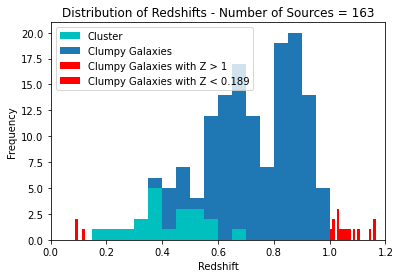

In [84]:
z_values = []
large_z_values,small_z_values = [],[]
counter = 0
count = 0

cluster_info = Table.read('/Users/brianmerino/Desktop/cluster_redshifts.txt',format='ascii')

min_z = np.min(cluster_info['z_cluster'])

for i in range(0,len(cat[magerr_col])):
    #cat['z_phot'] = zout['z_phot']
    if zout['z_phot'][i] > 1.0:
        large_z_values.append(zout['z_phot'][i])
        counter+=1
        
    elif zout['z_phot'][i] < min_z:
        small_z_values.append(zout['z_phot'][i])
        count+=1
        
    else:
        z_values.append(zout['z_phot'][i])
#cat.write('/Users/brianmerino/EAZY/galaxy_phot2.cat',format='ascii.commented_header')
bins = 20

print("Number of sources with z > 1: %s"%(counter))
print(large_z_values)
print()
print("Number of sources with z < %s: %s"%(str(min_z),count))
print(small_z_values)

plt.hist(cluster_info['z_cluster'],bins=bins,color='c',label='Cluster',zorder=10,range=(0.0,1.0))#,alpha=0.5)
plt.hist(z_values,bins=bins,label='Clumpy Galaxies',range=(0.0,1.0))
plt.hist(large_z_values,bins=bins,color='red',label='Clumpy Galaxies with Z > 1')
plt.hist(small_z_values,bins=3,color='red',label='Clumpy Galaxies with Z < %s'%(str(min_z)))
plt.title('Distribution of Redshifts - Number of Sources = %i'%(len(cat))) #excluding object with z > 2
plt.xlabel('Redshift')
plt.ylabel('Frequency')

plt.xlim(0.0,1.2)
plt.legend()


#plt.savefig('/Users/brianmerino/Desktop/z_dist.png')
plt.show()
#cluster_info.show_in_notebook()

### Diagnostic plots

/Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/utils.py:540: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(-6*sample_nmad, 6*sample_nmad)


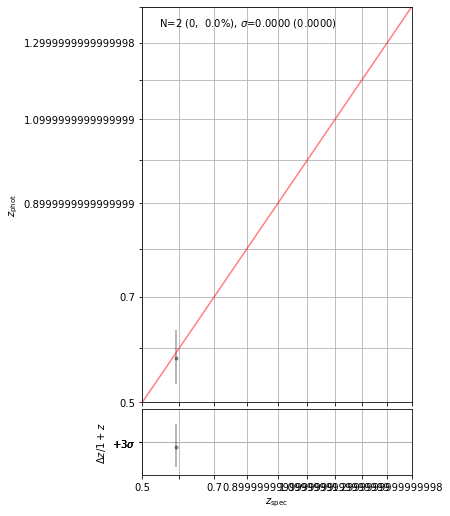

In [13]:
fig = ez.zphot_zspec(zmin=0.5, zmax=1.4, minor=0.1)

In [86]:
### UVJ
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])

uverr = 2.5*np.sqrt((zout['restU_err']/zout['restU'])**2+(zout['restV_err']/zout['restV'])**2)
vjerr = 2.5*np.sqrt((zout['restV_err']/zout['restV'])**2+(zout['restJ_err']/zout['restJ'])**2)

/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


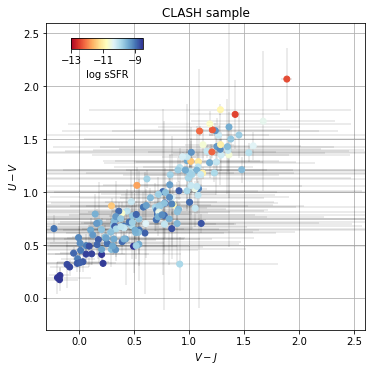

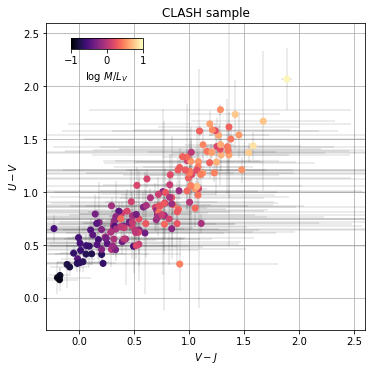

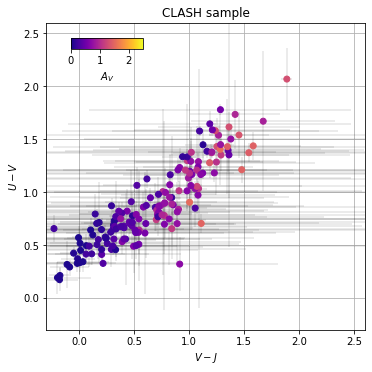

In [87]:
for show in ['ssfr', 'MLv', 'Av']:
    
    fig = plt.figure(figsize=[5,5])
    
    ax = fig.add_subplot(111)
    ax.errorbar(vj, uv, xerr=vjerr, yerr=uverr, color='k', 
                alpha=0.1, marker='.', capsize=0, linestyle='None')
    
    if show == 'ssfr':
        sc = ax.scatter(vj, uv, c=np.log10(zout['ssfr']), 
                        vmin=-13, vmax=-8.5, zorder=10, cmap='RdYlBu')
        label = 'log sSFR'
        ticks = np.arange(-13,-8,2)
    
    elif show == 'MLv':
        sc = ax.scatter(vj, uv, c=np.log10(zout['MLv']), 
                        vmin=-1, vmax=1, zorder=10, cmap='magma')
        label = r'$\log\ M/L_V$'
        ticks = np.arange(-1,1.1,1)

    elif show == 'Av':
        sc = ax.scatter(vj, uv, c=zout['Av'], vmin=0, 
                        vmax=2.5, zorder=10, cmap='plasma')
        label = r'$A_V$'
        ticks = np.arange(0,2.1,1)
    
    # Colorbar
    cax = fig.add_axes((0.18, 0.88, 0.2, 0.03))
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(label)
    cb.set_ticks(ticks)
    
    ax.set_xlim(-0.3, 2.6)
    ax.set_ylim(-0.3, 2.6)
    
    ax.grid()
    
    ax.set_xlabel(r'$V-J$'); ax.set_ylabel(r'$U-V$')
    ax.set_title('CLASH sample')
    
    fig.tight_layout(pad=0.1)
    
    plt.savefig('CLASH_sample_{0}.pdf'.format(show))

In [88]:
print('### These ids have redshifts that are too high ####')
counter=0
for j in range(0,len(cat)):
    if cat['z_phot'][j] > 1:
        print(str(j) + '\t' + str(cat['z_phot'][j]))
        counter+=1
print('###################################################')
print(str(counter)+' galaxies')

### These ids have redshifts that are too high ####
9	1.0304700136184692
26	1.1656183004379272
28	1.043616771697998
49	1.1415095329284668
55	1.0012903213500977
73	1.0720750093460083
76	1.055992841720581
77	1.0162280797958374
86	1.0321869850158691
98	1.0904344320297241
121	1.1653681993484497
124	1.0663995742797852
137	1.0315347909927368
142	1.0351208448410034
144	1.1071155071258545
146	1.013492465019226
###################################################
16 galaxies


0.2912584707499529

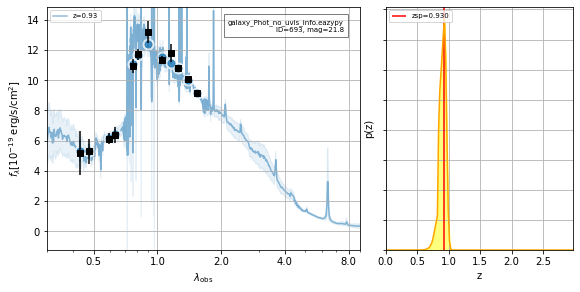

In [102]:
num = 56
#print(cat[num])
id_i = ez.cat['id'][num]
fig = ez.show_fit(id_i,show_fnu=0)
zout['Av'][61]

163
/Users/brianmerino/Desktop/Apperture_Test/macs1115-1476/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1115-1298/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1115-1267/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-1005/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-1437/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-1747/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-2185/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-283/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-352/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-358/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-689/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-694/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1149-825/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1206-1452/SED.png
/Users/brianmerino/Desktop/Apperture_Test/macs1206-1461/SED.png
/Users/brianmerino/Desktop/Apperture_Test/

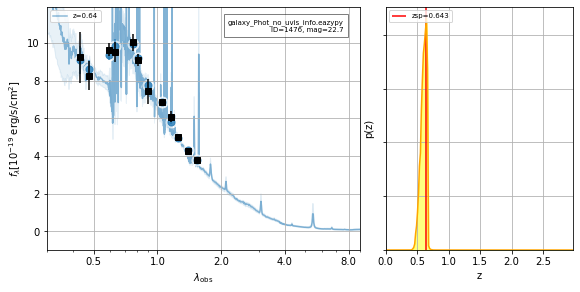

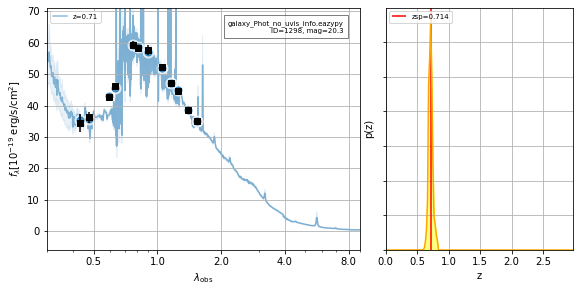

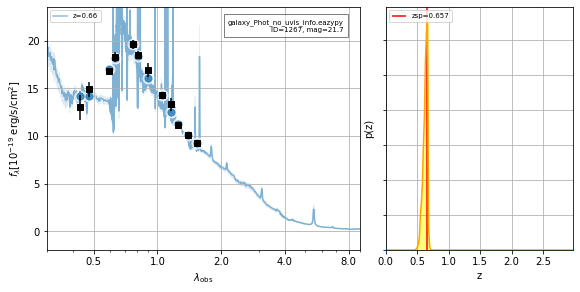

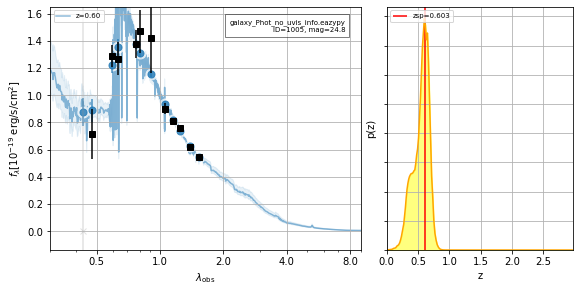

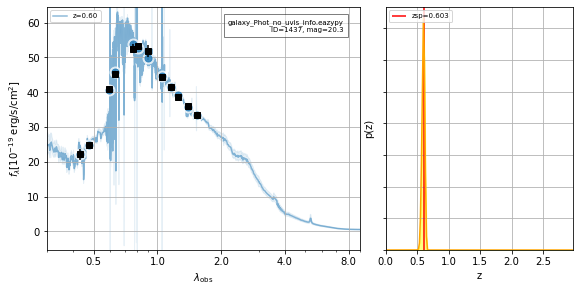

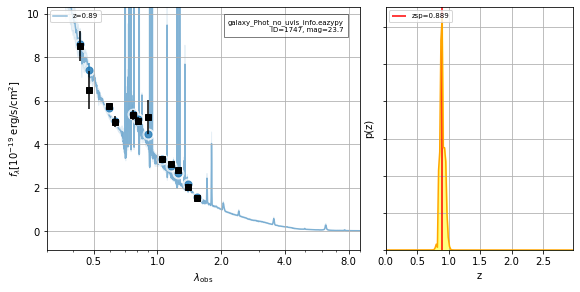

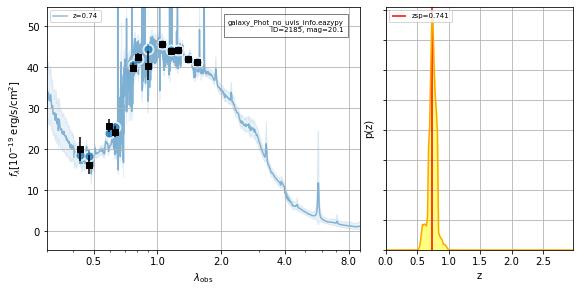

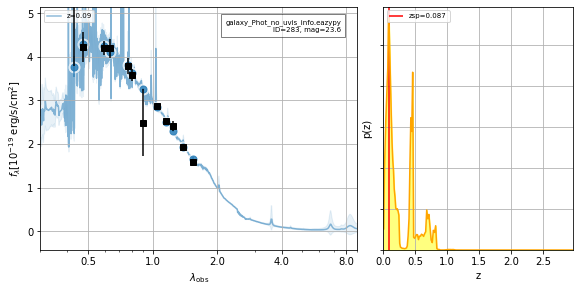

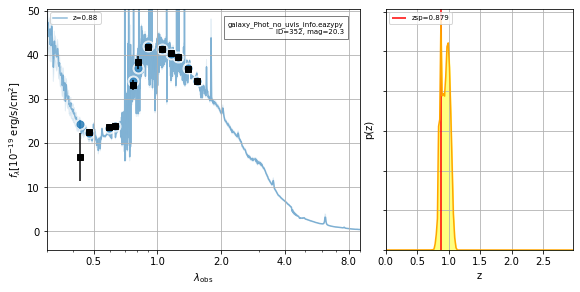

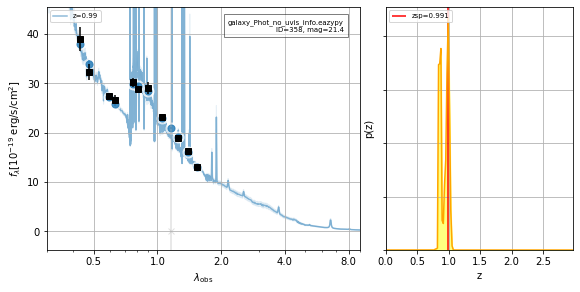

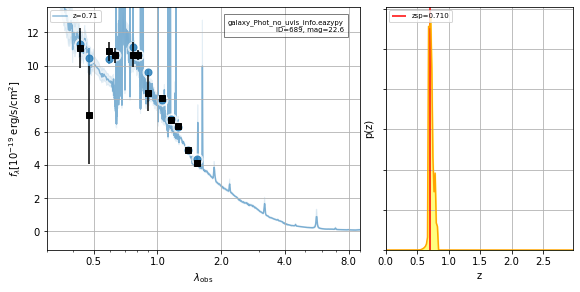

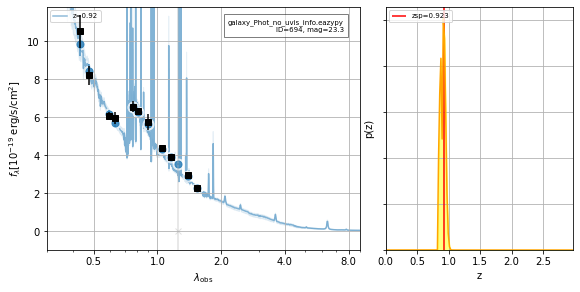

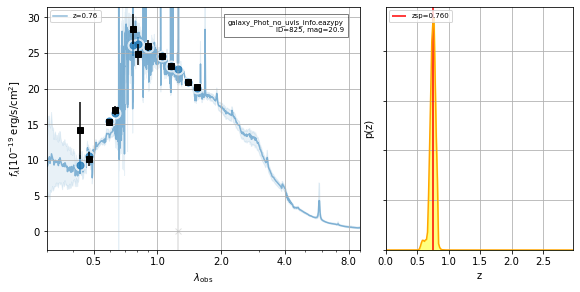

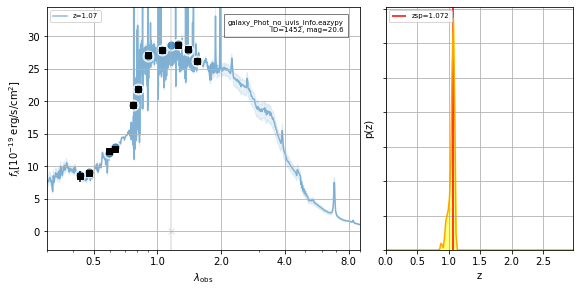

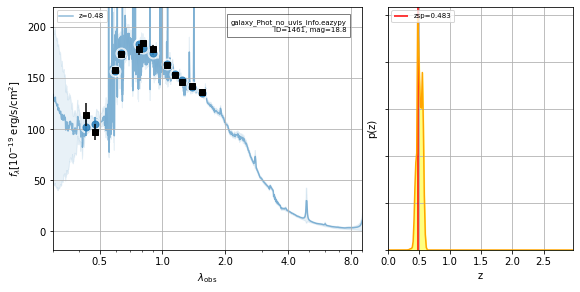

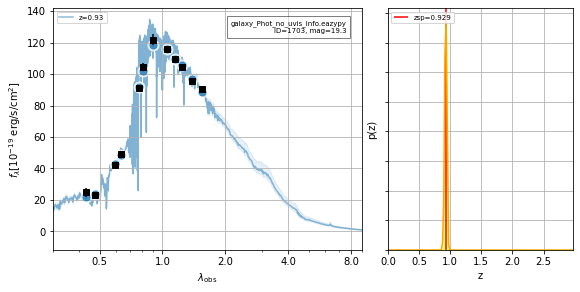

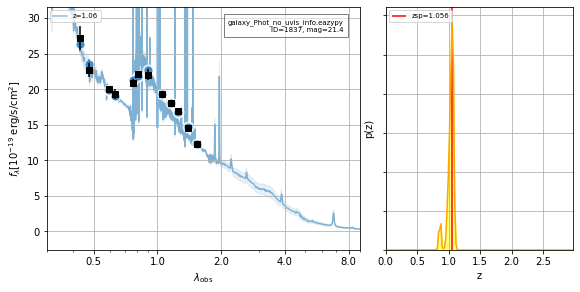

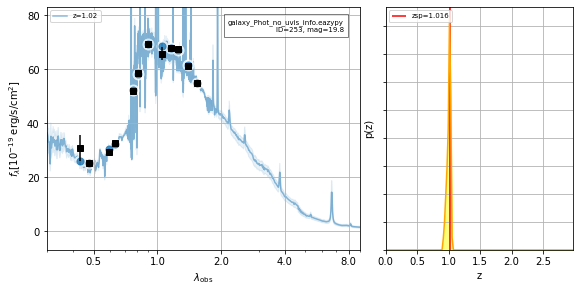

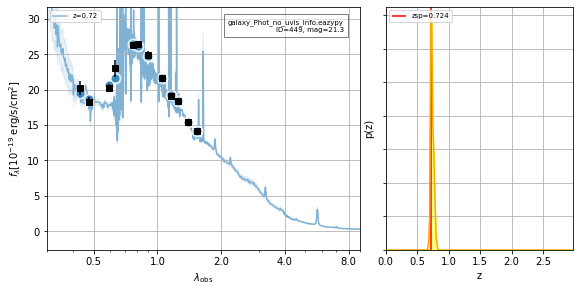

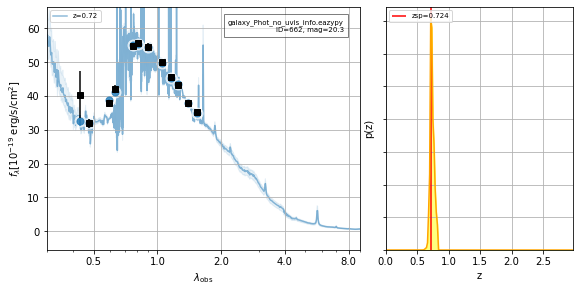

In [105]:
#This cell will save the SEDs
#NOTE: fig will automatically display the plot but Jupyter doesn't let more than 20
#plots show at a time, so make sure end-start <= 20.
print(len(cat))
count=0
start = 80
end   = 100
for i in range(start,end):
    id_i = ez.cat['id'][i]
    fig = ez.show_fit(id_i,show_fnu=0)
    count+=1
    plt.savefig('/Users/brianmerino/Desktop/Apperture_Test/%s-%s/SED.png'%(cat['cluster'][i],cat['id'][i]),facecolor='white', transparent=False)
    print('/Users/brianmerino/Desktop/Apperture_Test/%s-%s/SED.png'%(cat['cluster'][i],cat['id'][i]))
print(count)


/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


(0.0, 2.0)

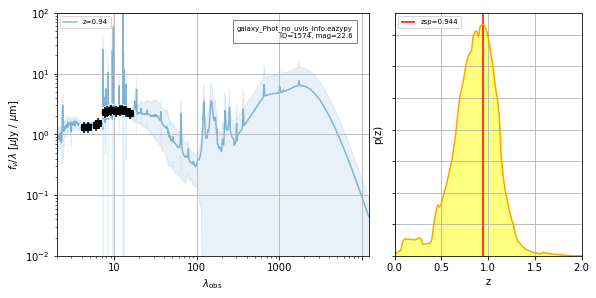

In [91]:
# nu-Fnu scaling for far-IR 
fig = ez.show_fit(id_i, show_fnu=2)

fig[0].axes[0].set_xlim(0.2, 1200)
fig[0].axes[0].set_ylim(0.01, 100)
fig[0].axes[0].loglog()
fig[0].axes[0].set_xticklabels([0.1, 1, 10, 100, 1000])
fig[0].axes[1].set_xlim(0, 2)

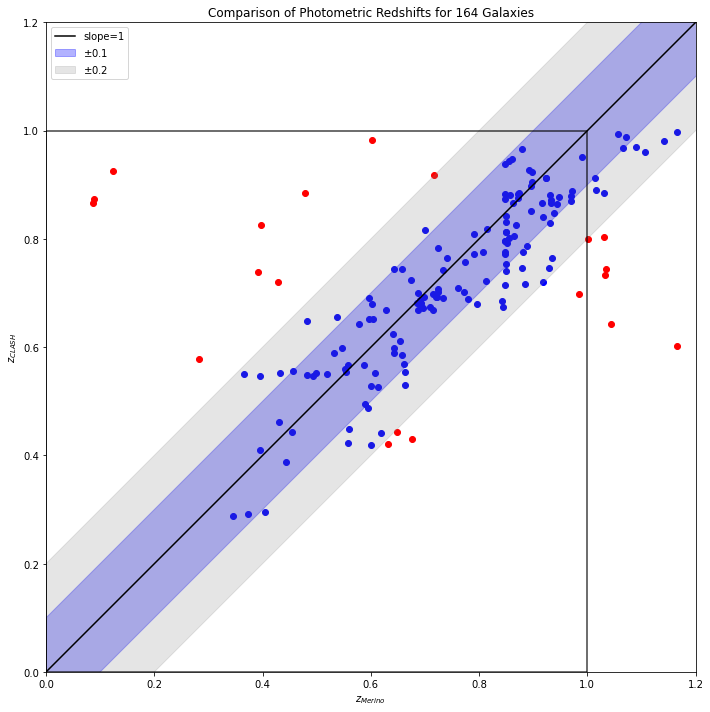

Number of galaxies: 164
The following 20 ids need to be investigated:
Cluster    id   z_merino   z_clash
a209       1772  0.48 0.88
a383       401   0.65 0.44
a383       799   0.28 0.58
a611       500   0.12 0.93
a611       769   1.17 0.60
macs0329   1903  1.04 0.64
macs0429   1424  0.39 0.74
macs0744   935   0.40 0.83
macs1115   511   1.00 0.80
macs1149   1005  0.60 0.98
macs1149   283   0.09 0.87
macs1311   307   1.03 0.73
macs1311   487   0.43 0.72
macs1423   90    0.09 0.87
rxj1347    240   1.03 0.80
rxj1347    452   0.98 0.70
rxj1532    1210  1.04 0.74
rxj2129    246   0.63 0.42
rxj2129    259   0.72 0.92
rxj2129    597   0.68 0.43


In [92]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

#cluster = 'a209'

UVIS = 0 # 0 if UVIS filters were left out of analysis

catalog_file = '/Users/brianmerino/EAZY/galaxy_phot2.cat'
catalog = Table.read(catalog_file,format = 'ascii')

start = 0
end   = 1.5


x = np.linspace(start,end,10)
y = np.linspace(start,end,10)


plt.figure(figsize=(10,10)) #fig size same as before
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)


bad_ids,bad_clusters = [],[]
bad_clash,bad_merino = [],[]

for j in range(0,len(catalog)):
    phot = catalog['z_phot'][j] 
    zb = catalog['zb'][j]
    
    if phot > zb+0.2 or phot < zb-0.2:
        plt.scatter(catalog['z_phot'][j],catalog['zb'][j],c='r')
        bad_ids.append(catalog['id'][j])
        bad_clusters.append(catalog['cluster'][j])
        bad_clash.append(catalog['zb'][j])
        bad_merino.append(catalog['z_phot'][j])
    else:
        plt.scatter(catalog['z_phot'][j],catalog['zb'][j],c='b')
        

plt.plot(x,y,label='slope=1',c='black')
plt.fill_between(x,y-0.1,y+0.1,color='blue',alpha=0.3,label='$\pm$0.1')
plt.fill_between(x,y-0.2,y+0.2,color='gray',alpha=0.2,label='$\pm$0.2')
plt.xlabel('$z_{Merino}$')
plt.ylabel('$z_{CLASH}$')

alpha = 0.75
plt.hlines(0,0,1,color='black',alpha=alpha)
plt.vlines(0,0,1,color='black',alpha=alpha)
plt.hlines(1,0,1,color='black',alpha=alpha)
plt.vlines(1,0,1,color='black',alpha=alpha)

plt.legend(loc=2)
#plt.ylim(start,1.5)
ax.set_xlim([0, 1.2])
ax.set_ylim([0, 1.2])

plt.title('Comparison of Photometric Redshifts for %s Galaxies'%(len(catalog)))
plt.tight_layout()
#plt.savefig('/Users/brianmerino/Downloads/z_vs_z.png')
plt.show()


print('Number of galaxies: %s'%(len(catalog)))
print('The following %s ids need to be investigated:'%(len(bad_ids)))
print('%7s    %1s   %s   %1s'%('Cluster','id','z_merino','z_clash'))

    
for n in range(0,len(bad_ids)):
    print('%-10s'%(bad_clusters[n]),'%-5i'%(bad_ids[n]),\
          '%.2f'%(bad_merino[n]),'%.2f'%(bad_clash[n]))

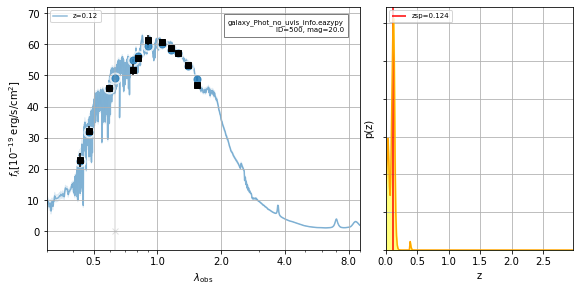

In [93]:
id_i = ez.cat['id'][24]
fig = ez.show_fit(id_i,show_fnu=0)
plt.savefig('/Users/brianmerino/Downloads/SED.png')


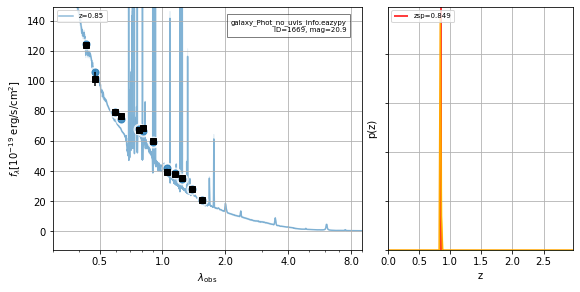

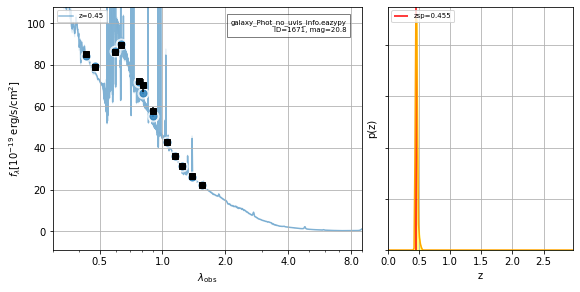

In [94]:
#for i in range(0,len(cat)):
for i in range(4,6):
    id_i = ez.cat['id'][i]
    fig = ez.show_fit(id_i,show_fnu=0)
plt.savefig('/Users/brianmerino/Downloads/SED.png')
    #fig[0].axes[0].set_ylim(0, 16)

In [95]:
#This cell prints the name of each cluster along with its coordinates
cluster_name = 'none'
counter = 0
print('#############################')
print('#%-8s %-9s %-8s#'%('Cluster','RA','DEC'))
print('#############################')
for c in range(0,len(cat['cluster'])):
    if cluster_name != cat['cluster'][c]:
        cluster_name = cat['cluster'][c]
        print('%-8s %f %f'%(cluster_name,cat['RA'][c],cat['DEC'][c]))
        counter +=1
#print(counter)    
    

#############################
#Cluster  RA        DEC     #
#############################
a209     22.973038 -13.597318
a383     42.015583 -3.508325
a611     120.224554 36.053051
macs0329 52.434917 -2.204998
macs0416 64.024571 -24.073642
macs0429 67.386437 -2.891522
macs0717 109.376738 37.753479
macs0744 116.226392 39.461100
macs1115 168.946854 1.506416
macs1149 177.396887 22.398070
macs1206 181.571475 -8.807194
macs1311 197.772604 -3.177227
macs1423 215.969846 24.076751
macs1720 260.076871 35.627610
macs1931 292.967358 -26.583314
macs2129 322.368067 -7.693056
ms2137   325.073754 -23.665161
rxj1347  206.882121 -11.736369
rxj1532  233.226529 30.341465
rxj2129  322.403642 0.087961


In [96]:
#This cell prints out the photo z and the 2.5th and 50th percentiles
count=0
print('%-10s %-10s %-10s %-10s'%('z_phot','z_160','z_500','z_840'))
for t in range(0,len(zout['z_phot'])):
    print('%-10f %-10f %-10f %-10f'%(zout['z_phot'][t],zout['z160'][t],zout['z500'][t],zout['z840'][t]))
    count+=1
print()
print(count)



z_phot     z_160      z_500      z_840     
0.848497   0.821992   0.863674   0.899834  
0.594109   0.515208   0.577093   0.604328  
0.590003   0.568169   0.588522   0.605420  
0.395389   0.317817   0.365143   0.399967  
0.848536   0.840772   0.845939   0.853200  
0.454836   0.441778   0.456759   0.474134  
0.699515   0.670559   0.705968   0.747845  
0.479107   0.443964   0.538789   0.670502  
0.404193   0.289246   0.455276   0.644130  
1.030470   0.857795   1.074291   1.583037  
0.372884   0.269098   0.401826   0.573716  
0.648837   0.428927   0.614100   0.782681  
0.282600   0.226714   0.350115   0.508815  
0.789935   0.578329   0.775513   0.948255  
0.433011   0.292169   0.458060   0.647104  
0.663876   0.438449   0.633628   0.817198  
0.915566   0.711957   0.897859   1.072038  
0.862921   0.676119   0.870520   1.047617  
0.618015   0.382310   0.574800   0.748289  
0.943480   0.637064   0.875025   1.073932  
0.346273   0.259929   0.398138   0.569473  
0.851142   0.671330   0.879600  

In [97]:
#cat.add_column(-99.99,name='z_160')
#cat.add_column(-99.99,name='z_500')
#cat.add_column(-99.99,name='z_840')

for t in range(0,len(zout['z_phot'])):
    cat['z_160'][t] = round(zout['z160'][t],4)
    cat['z_500'][t] = round(zout['z500'][t],4)
    cat['z_840'][t] = round(zout['z840'][t],4)   
    
cat.show_in_notebook()

idx,cluster,id,obj,RA,DEC,area,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,f225w_flux,f225w_fluxerr,f275w_flux,f275w_fluxerr,f336w_flux,f336w_fluxerr,f390w_flux,f390w_fluxerr,f435w_flux,f435w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f160w_flux,f160w_fluxerr,z_phot,z_eazy,z_conner,z_160,z_500,z_840,z_spec
0,a209,218,-1,22.9730375,-13.5973175,-99,0.939,21.022,0.025,-99.0,-99.0,22.711,0.068,24.107,0.13,24.274,0.114,24.094,0.068,23.743,0.033,23.941,0.068,22.948,0.034,22.67,0.02,22.769,0.06,22.679,0.015,22.58,0.008,22.393,0.012,22.3,0.009,22.298,0.014,14.164459272385136,0.3261487277091531,-99,-99,2.989509927814587,0.18723394706790525,0.826418441715795,0.09895073679244823,0.7085981269167676,0.07440130126866958,0.8363729915840239,0.05238230352683446,1.1555799554021289,0.035122839563746,0.9629417129715555,0.06030934235692439,2.4032558049332398,0.07525833347883332,3.104559588128347,0.057188101023488536,2.834001005509097,0.15661268325156918,3.078931309741611,0.042537008016982,3.37287308658869,0.024852247327167787,4.006821541822104,0.04428502825193758,4.365158322401652,0.03618413453419539,4.373206651696452,0.05639021049076047,0.8484974503517151,0.8485,0.903,0.8220000267028809,0.8636999726295471,0.8998000025749207,0.8485
1,a209,1020,-1,22.978324999999998,-13.612234166666667,-99,0.488,-99.0,-99.0,-99.0,-99.0,21.628,0.032,22.892,0.055,22.664,0.034,22.573,0.022,21.845,0.007,21.672,0.011,21.32,0.01,21.218,0.007,21.196,0.018,21.105,0.005,21.089,0.003,21.036,0.004,20.947,0.003,20.869,0.005,-99.0,-99.0,-99,-99,8.105876824647362,0.23890523061861027,2.5304630494613947,0.1281853429133654,3.121763510848157,0.09775851528547144,3.3946890538007795,0.06878573161355929,6.637430704019088,0.04279309718559492,7.783949326267247,0.07886210500644963,10.764652136298333,0.09914611016122821,11.824968703831036,0.07623839065517492,12.067019095932718,0.200054435667618,13.121998990192008,0.060429038530198084,13.316803762699811,0.036795688596383526,13.982988484658337,0.051515233344450705,15.177491558612486,0.041936958974284885,16.30797361023593,0.0751009938637391,0.5941091179847717,0.5941,0.539,0.5152000188827515,0.5770999789237976,0.6043000221252441,0.5941
2,a209,1312,-1,22.97045,-13.616914166666668,-99,0.495,-99.0,-99.0,-99.0,-99.0,21.793,0.036,22.677,0.042,22.647,0.031,22.343,0.016,21.631,0.006,21.464,0.008,21.116,0.008,21.062,0.006,21.001,0.014,20.965,0.004,20.951,0.002,20.896,0.004,20.831,0.003,20.775,0.004,-99.0,-99.0,-99,-99,6.963057796029312,0.23087567639222017,3.0846081377571397,0.1193232216242256,3.1710274389478936,0.09053935032891668,4.195657223387249,0.061829489778459326,8.083510373900667,0.04467112916641537,9.427575085274157,0.0694649403341899,12.989726288978538,0.09571184036823951,13.652116950664434,0.07544438634818701,14.441090844161184,0.18621030682429474,14.927944095789943,0.05499657847042305,15.121678487917649,0.027855161173862338,15.907429237502162,0.05860513508820819,16.88884694790917,0.04666560866413637,17.78279410038923,0.06551423457174192,0.5900025367736816,0.59,0.493,0.5681999921798706,0.5885000228881836,0.605400025844574,0.59
3,a209,1602,-1,22.96975,-13.621598888888888,-99,0.547,-99.0,-99.0,-99.0,-99.0,22.891,0.087,23.128,0.057,23.884,0.086,22.976,0.026,22.402,0.01,22.288,0.016,22.081,0.016,22.072,0.013,22.152,0.037,22.227,0.011,22.268,0.007,22.304,0.012,22.277,0.01,22.276,0.015,-99.0,-99.0,-99,-99,2.5327947656899945,0.20295274639397126,2.036104201131967,0.10689331253384562,1.0148456628180937,0.080384

In [98]:
#cat.remove_columns(['z_160','z_500','z_840'])
cat.write(file,format='ascii.commented_header')

In [99]:
#This cell opens a catalog I created of my clumpy galaxies that Tom has spec z's for
spec_path = 'galaxy_spec_z.cat'
test = Table.read(spec_path,format='ascii.commented_header')


for t in range(0,len(test)):
    if test['z_spec_conner'][t] > 1.1984:
        print('%s %i %f'%(test['cluster'][t],test['id'][t],test['z_spec_conner'][t]))
test.show_in_notebook()


idx,cluster,id,obj,RA,DEC,area,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,f225w_flux,f225w_fluxerr,f275w_flux,f275w_fluxerr,f336w_flux,f336w_fluxerr,f390w_flux,f390w_fluxerr,f435w_flux,f435w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f160w_flux,f160w_fluxerr,z_phot,z_eazy,z_conner,z_160,z_500,z_840,z_spec_conner
0,a383,193,-1,42.006233333333334,-3.5095191666666667,-99,0.291,21.702,-99.0,21.562,-99.0,21.389,-99.0,21.329,-99.0,21.194,-99.0,20.934,-99.0,20.476,-99.0,20.377,-99.0,20.32,-99.0,20.227,-99.0,20.105,-99.0,20.165,-99.0,20.108,-99.0,inf,-99.0,20.01,-99.0,19.966,-99.0,7.571815097147034,1.5143630194294069,8,1,10.101828705448325,2.020365741089665,10.675789450994925,2.135157890198985,12.089267852132995,2.4178535704265993,15.360310683850239,3.072062136770048,23.42070694793825,4.6841413895876505,25.65665297034868,5.131330594069737,27.039583641088406,5.407916728217682,29.45777902339455,5.8915558046789105,32.96097121774573,6.592194243549146,31.188895840939352,6.2377791681878705,32.87002239687747,6.5740044793754935,-99.0,-99.0,35.97493351557414,7.194986703114829,37.4627798344059,7.492555966881181,0.3728836476802826,0.3729,0.291,0.26910001039505005,0.4018000066280365,0.5737000107765198,0.3219
1,a383,799,-1,42.01176666666667,-3.524363888888889,-99,0.579,22.311,-99.0,21.99,-99.0,21.758,-99.0,21.758,-99.0,21.714,-99.0,21.442,-99.0,20.649,-99.0,20.462,-99.0,19.873,-99.0,19.764,-99.0,19.595,-99.0,19.285,-99.0,19.192,-99.0,19.112,-99.0,18.972,-99.0,18.815,-99.0,4.321156544702986,0.8642313089405973,5,1,7.19117735782509,1.438235471565018,7.19117735782509,1.438235471565018,7.488589075216439,1.4977178150432877,9.620552191862133,1.9241104383724268,19.97100866028181,3.9942017320563625,23.724660151048074,4.744932030209615,40.81313915969713,8.162627831939426,45.12321133443373,9.024642266886746,52.722986142282274,10.544597228456455,70.14552984199703,14.029105968399406,76.41876239634668,15.283752479269337,82.26213938831106,16.452427877662213,93.58365435835277,18.716730871670556,108.14339512979353,21.628679025958707,0.282600462436676,0.2826,0.593,0.22669999301433563,0.35010001063346863,0.5088000297546387,0.6561
2,a383,2280,-1,41.99729583333333,-3.5517055555555554,-99,0.884,inf,-99.0,inf,-99.0,inf,-99.0,inf,-99.0,24.066,-99.0,24.001,-99.0,23.394,-99.0,23.241,-99.0,22.399,-99.0,22.199,-99.0,21.872,-99.0,21.662,-99.0,inf,-99.0,21.32,-99.0,inf,-99.0,21.05,-99.0,-99.0,-99.0,-99,-99,-99.0,-99.0,-99.0,-99.0,0.8582227050540148,0.17164454101080295,0.911171233042917,0.18223424660858342,1.5936758810287672,0.3187351762057535,1.834847607755538,0.3669695215511076,3.9847400971777436,0.7969480194355487,4.790711300030731,0.9581422600061462,6.474407045688144,1.2948814091376288,7.855973322609894,1.571194664521979,-99.0,-99.0,10.764652136298333,2.1529304272596668,-99.0,-99.0,13.803842646028825,2.760768529205765,0.8737236857414246,0.8737,0.872,0.6417999863624573,0.8718000054359436,1.094599962234497,1.1984
3,a383,2443,-1,42.012075,-3.5579508333333334,-99,0.288,inf,-99.0,inf,-99.0,inf,-99.0,inf,-99.0,21.366,-99.0,21.004,-99.0,20.376,-99.0,20.237,-99.0,19.909,-99.0,19.831,-99.0,19.739,-99.0,19.584,-99.0,inf,-99.0,19.43,-99.0,inf,-99.0,19.253,-99.0,-99.0,-99.0,-99,-99,-99.0,-99.0,-99.0,-99.0,10.318106352675912,2.0636212705351826,14.40124371175567,2.8802487423511343,25.68029450667344,5.136058901334689,29.187708481971452,5.8375416963942905,39.48207780378827,7.896415560757655,42.42286549229502,8.484573098459004,46.17426594772946,9.23

(0.0, 1.3)

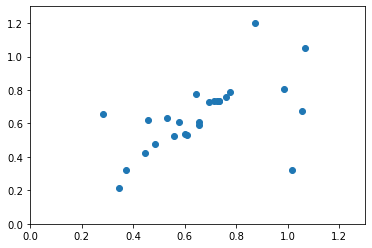

In [100]:
spec_z,phot_z = [],[]

x_min,x_max = 0.0,1.3
y_min,y_max = 0.0,1.3

for n in range(0,len(test)):
    spec_z.append(test['z_spec_conner'][n])
    phot_z.append(test['z_eazy'][n])
    
plt.scatter(phot_z,spec_z)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

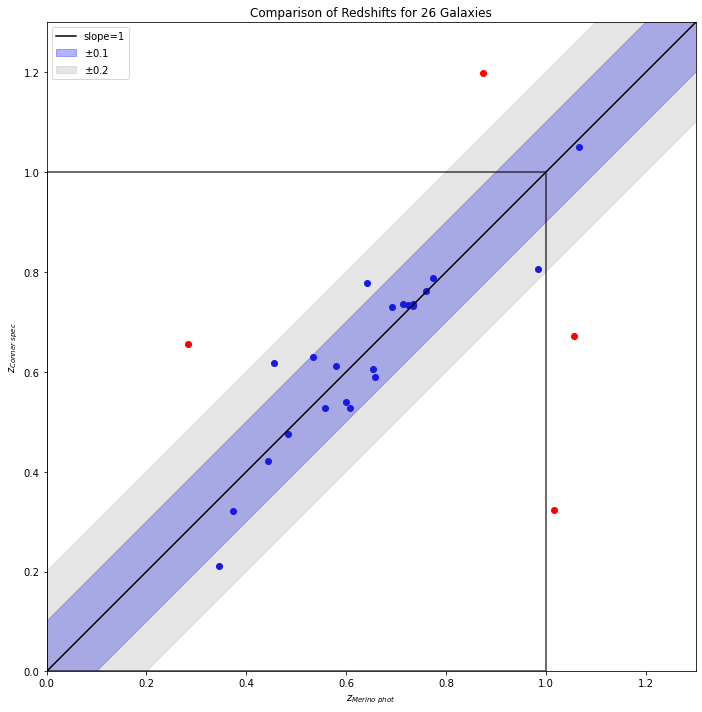

Number of galaxies: 26
The following 4 ids need to be investigated:
Cluster    id   z_merino   z_clash
a383       799   0.28 0.66
a383       2280  0.87 1.20
macs1206   253   1.02 0.32
macs1206   1837  1.06 0.67


In [101]:
#spec_z,phot_z = [],[]

start = 0
end   = 1.5

x = np.linspace(start,end,10)
y = np.linspace(start,end,10)

plt.figure(figsize=(10,10)) #fig size same as before
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)

bad_ids,bad_clusters = [],[]
bad_clash,bad_merino = [],[]

for j in range(0,len(test)):
    phot = test['z_eazy'][j] 
    spec = test['z_spec_conner'][j]
    
    if phot > spec+0.2 or phot < spec-0.2:
        plt.scatter(test['z_eazy'][j],test['z_spec_conner'][j],c='r')
        bad_ids.append(test['id'][j])
        bad_clusters.append(test['cluster'][j])
        bad_clash.append(test['z_spec_conner'][j])
        bad_merino.append(test['z_eazy'][j])
    else:
        plt.scatter(test['z_eazy'][j],test['z_spec_conner'][j],c='b')
        

plt.plot(x,y,label='slope=1',c='black')
plt.fill_between(x,y-0.1,y+0.1,color='blue',alpha=0.3,label='$\pm$0.1')
plt.fill_between(x,y-0.2,y+0.2,color='gray',alpha=0.2,label='$\pm$0.2')
plt.xlabel('$z_{Merino\ phot}$')
plt.ylabel('$z_{Conner\ spec}$')

alpha = 0.75
plt.hlines(0,0,1,color='black',alpha=alpha)
plt.vlines(0,0,1,color='black',alpha=alpha)
plt.hlines(1,0,1,color='black',alpha=alpha)
plt.vlines(1,0,1,color='black',alpha=alpha)

plt.legend(loc=2)
#plt.ylim(start,1.5)
ax.set_xlim([0, 1.3])
ax.set_ylim([0, 1.3])

plt.title('Comparison of Redshifts for %s Galaxies'%(len(test)))
plt.tight_layout()
#plt.savefig('/Users/brianmerino/Downloads/z_photvs_z_spec.png',facecolor='white', transparent=False)
plt.show()


print('Number of galaxies: %s'%(len(test)))
print('The following %s ids need to be investigated:'%(len(bad_ids)))
print('%7s    %1s   %s   %1s'%('Cluster','id','z_merino','z_clash'))

    
for n in range(0,len(bad_ids)):
    print('%-10s'%(bad_clusters[n]),'%-5i'%(bad_ids[n]),\
          '%.2f'%(bad_merino[n]),'%.2f'%(bad_clash[n]))